<a href="https://colab.research.google.com/github/andBabaev/ds_school_2020/blob/master/task%204/Babaev_Andrei_keras_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1gSdzCpfIrC2Mu2-HK8td_9qSJ-y7ENUbb)


In [1]:
!pip install cpi
!pip install --upgrade tqdm

     |████████████████████████████████| 25.5MB 168kB/s 
     |████████████████████████████████| 71kB 2.1MB/s 
  Found existing installation: tqdm 4.38.0
    Uninstalling tqdm-4.38.0:
      Successfully uninstalled tqdm-4.38.0


In [0]:
import warnings
warnings.simplefilter('ignore')

import json
import cpi

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tqdm.keras import TqdmCallback
from keras.initializers import glorot_uniform 
from tensorflow.random import set_seed
from keras import optimizers
from keras.constraints import maxnorm

# TMDB

In [0]:
data = pd.read_csv('drive/My Drive/tmdb_5000_movies.csv')

In [4]:
data = data.drop(['tagline', 'overview', 'homepage', 'original_title', 'id', 'status'], axis=1)
print(data.shape)
data = data[(data['runtime']!=0.0) &
            (data['revenue']!=0.0)]

(4803, 14)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3375 entries, 0 to 4798
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3375 non-null   int64  
 1   genres                3375 non-null   object 
 2   keywords              3375 non-null   object 
 3   original_language     3375 non-null   object 
 4   popularity            3375 non-null   float64
 5   production_companies  3375 non-null   object 
 6   production_countries  3375 non-null   object 
 7   release_date          3375 non-null   object 
 8   revenue               3375 non-null   int64  
 9   runtime               3375 non-null   float64
 10  spoken_languages      3375 non-null   object 
 11  title                 3375 non-null   object 
 12  vote_average          3375 non-null   float64
 13  vote_count            3375 non-null   int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 395.5+ KB


## Data preparation

In [0]:
data['release_date'] = pd.to_datetime(data['release_date'])
data.sort_values('release_date', inplace=True)
data['release_month'] = data['release_date'].dt.month
data['release_dayofweek'] = data['release_date'].dt.dayofweek
data['release_year'] = data['release_date'].dt.year

data['decade'] = data['release_year'].apply(lambda x: str(x)[:-1])

def fix_inflation(row):
    row['revenue_fix'] = cpi.inflate(row['revenue'], row['release_date'])
    row['budget_fix'] = cpi.inflate(row['budget'], row['release_date'])

    return row

data = data.apply(fix_inflation,axis=1)

def get_dict_value(row, feature, target_key='name'):
    list_ = json.loads(row[feature])
    row[feature+'_1'] = list_[0][target_key] if list_ else None

    return row
    
data = data.apply(get_dict_value, args=('genres',), axis=1)
data = data.apply(get_dict_value, args=('production_companies',), axis=1)
data = data.apply(get_dict_value, args=('production_countries',), axis=1)

clearned_data = data.copy()
clearned_data.drop(['genres', 'keywords', 'production_companies', 
                    'production_countries', 'spoken_languages', 
                    'release_date', 'popularity', 'vote_count', 
                    'revenue', 'budget', 'title', 'vote_average'], axis=1, inplace=True
                   )

clearned_data['genres_1'].fillna('na', inplace=True)
clearned_data['production_companies_1'].fillna('na', inplace=True)
clearned_data['production_countries_1'].fillna('na', inplace=True)

for feature, threshold in zip (['genres_1', 'production_companies_1', 'production_countries_1', 'original_language'], [20, 6, 2000, 3000]):
    count_data = clearned_data[feature].value_counts()
    values_for_replacing = count_data[count_data < threshold].index
    clearned_data[feature] = clearned_data[feature].apply(lambda x: 'Others' if x in values_for_replacing else x)

numerical_col = ['budget_fix',	'runtime']
for feature in numerical_col:
    clearned_data[feature+'_log'] = np.log(clearned_data[feature]+1)

## New target variable

In [7]:
qu1 = clearned_data['revenue_fix'].quantile(0.33)
qu2 = clearned_data['revenue_fix'].quantile(0.66)
print(qu1, qu2)
def get_classes(row):
    class_ = None
    if row['revenue_fix'] < qu1:
        row['revenue_class'] = 0
    elif qu1 <= row['revenue_fix'] < qu2:
        row['revenue_class'] = 1
    elif row['revenue_fix'] >= qu2:
        row['revenue_class'] = 2
    return row

clearned_data = clearned_data.apply(get_classes, axis=1)
clearned_data['revenue_class'].value_counts(normalize=True)

39146044.70122607 141064203.59021637


2    0.340148
0    0.330074
1    0.329778
Name: revenue_class, dtype: float64

# Train-test-split

In [0]:
X_cat_oh = pd.get_dummies(clearned_data[['genres_1', 
                                        'production_companies_1', 
                                        'production_countries_1', 
                                         'release_dayofweek',
                                         'release_month',
                                         'decade',
                                         ]])
X_numeric = clearned_data[['budget_fix_log', 'runtime_log']]

y = clearned_data['revenue_class']
n_classes = np.unique(y).shape[0]
y_cat = pd.get_dummies(y).values

shuffle=False because I want to train models to predict revenue_class for modern movies

In [9]:
r_state = 42
X_cat_oh_train, X_cat_oh_test, y_train, y_test = train_test_split(X_cat_oh, y_cat, 
                                                                  test_size=0.2, 
                                                                  shuffle=False, 
                                                                  #stratify=y,
                                                                  random_state=r_state,
                                                                  )

X_numeric_train, X_numeric_test = train_test_split(X_numeric,
                                                    test_size=0.2, 
                                                    shuffle=False,
                                                    #stratify=y,
                                                    random_state=r_state,
                                                   )

scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_test_scaled = scaler.transform(X_numeric_test)

X_train = np.hstack([X_numeric_train_scaled, X_cat_oh_train, ])
X_test = np.hstack([X_numeric_test_scaled, X_cat_oh_test, ])

print('\nTrain data', X_train.shape, '\nTest data', X_test.shape)


Train data (2700, 108) 
Test data (675, 108)


# Neural network

In [0]:
seed = 42
np.random.seed(seed)
set_seed(seed)

In [0]:
model = Sequential([
    Dense(60, kernel_initializer=glorot_uniform(seed=seed), input_shape=(X_train.shape[1],)),
    Activation('sigmoid'),
    Dense(20, kernel_initializer=glorot_uniform(seed=seed)),
    Activation('sigmoid'),
    Dense(n_classes, kernel_initializer=glorot_uniform(seed=seed)),
    Activation('softmax'),
])

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [372]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=10, verbose=0, callbacks=[TqdmCallback(verbose=0)],)

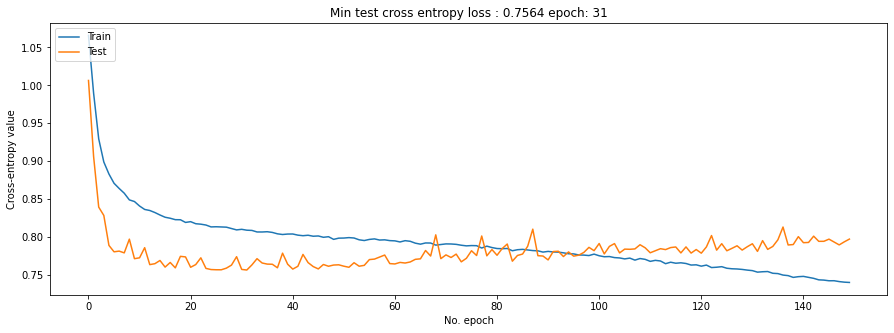

In [373]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Min test cross entropy loss : %.4f epoch: %s' % (np.min((history.history['val_loss'])), np.argmin(history.history['val_loss'])))
plt.ylabel('Cross-entropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

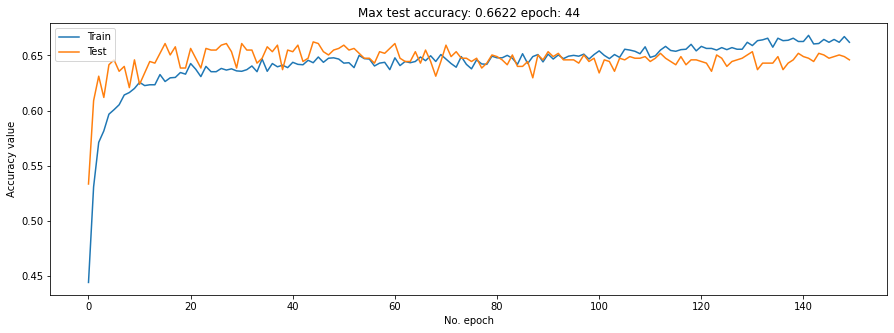

In [374]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Max test accuracy: %.4f epoch: %s' % (np.max((history.history['val_accuracy'])), np.argmax(history.history['val_accuracy'])))
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Dropout

In [0]:
seed = 42
np.random.seed(seed)
set_seed(seed)

In [0]:
model = Sequential([
    Dense(60, kernel_initializer=glorot_uniform(seed=seed), 
          input_shape=(X_train.shape[1],)),
    Dropout(0.1),
    Activation('sigmoid'),
    Dense(60, kernel_initializer=glorot_uniform(seed=seed)), 
    Dropout(0.1),
    Activation('sigmoid'),
    Dense(n_classes, kernel_initializer=glorot_uniform(seed=seed)),
    Activation('softmax'),
])

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [385]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=10, verbose=0, callbacks=[TqdmCallback(verbose=0)],)

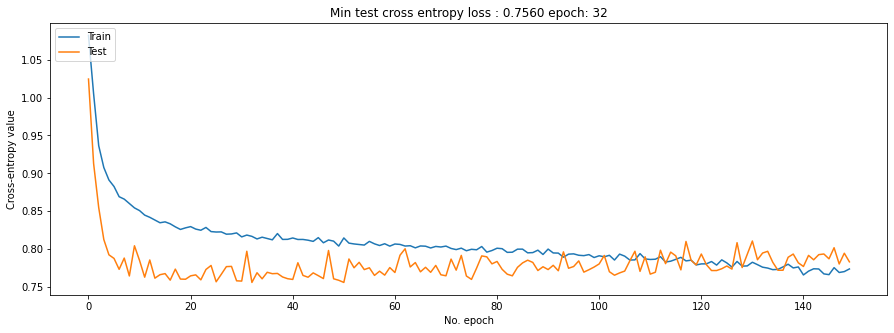

In [386]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Min test cross entropy loss : %.4f epoch: %s' % (np.min((history.history['val_loss'])), np.argmin(history.history['val_loss'])))
plt.ylabel('Cross-entropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

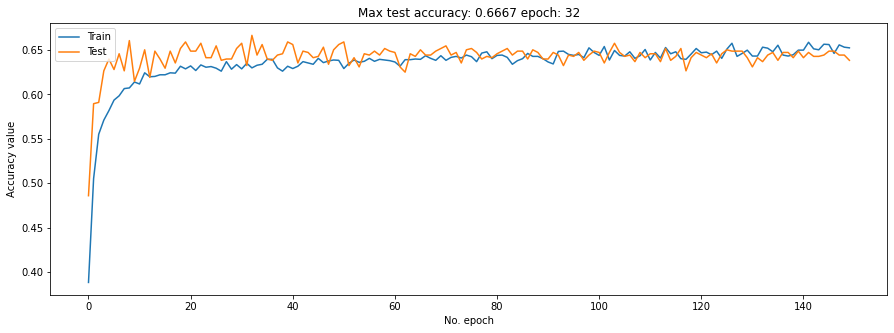

In [387]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Max test accuracy: %.4f epoch: %s' % (np.max((history.history['val_accuracy'])), np.argmax(history.history['val_accuracy'])))
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Testing of the model

In [388]:
print(classification_report(y_test.argmax(axis=1), model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70       220
           1       0.51      0.46      0.48       224
           2       0.76      0.69      0.73       231

    accuracy                           0.64       675
   macro avg       0.64      0.64      0.64       675
weighted avg       0.64      0.64      0.64       675



# Conclusions

Keras implementation of neural network has higher accuracy score than my implementation:

*   Keras nn - the best accuracy = 66.67%; learning is much faster
*   My NN from task 3 - the best accuracy = 65.48% 

In addition, it should be noted that the dropout allowed to reduce overfitting.

**Note.** I fixed my NN and got accuracy=66.96%. I fixed dropout and added biases

